In [16]:
%matplotlib inline
import matplotlib.pyplot as plt


# Adaptive PID control on an FPAA

## Standard PID control

Here is a P (proportional) controller:

$u = K_p(x_d - x)$

where $u$ is the output you will send to your controller, $x$ is your current state, and $x_d$ is your desired state.  $K_p$ is a constant that scales the output.

The next thing people generally add is a derivative term, making it a PD controller.  The purpose of this is to reduce the overshoot.

$u = K_p(x_d - x) + K_d(\dot x_d - \dot x)$

where $\dot x$ is the time derivative of $x$ (i.e. if $x$ is the position of a motor, then $\dot x$ is its velocity.  $\dot x_d$ is the desired velocity, which is often just set to 0.

This will work fine if there are no external forces on the system.  But, if there are such forces (e.g. gravity), then there will be many situations where the force being created by $u$ is exactly cancelled out by those external forces, resulting in the system stopping where $x \neq x_d$.  So, we need another term.

$u = K_p(x_d - x) + K_d(\dot x_d - \dot x) + K_i(\int_0^t x_d - x ~dt)$

That is, we integrate the positional error $x_d - x$ and apply that as another term (scaled by $K_i$).   This is now a standard PID controller.  Now, instead of being stuck when the external forces cancel out the PD terms, the positional error will gradually push the system harder and harder until it counteracts those forces.  



## Adaptive PID control

The idea behind adaptive PID control (Slotine and Li, 1987) is to note that the correct amount of external force is usually a function of some state information.  For example, if this is an inverted pendulum, when the arm is horizontal to the left, gravity applies a counter-clockwise torque, but if it's all the way to the right we have a clockwise torque.  What would be great is instead of learning a single scalar value $K_i(\int_0^t x_d - x ~dt)$, we instead learn something that is a function of the state of the system.

The way we're going to do this is to start by noting that we can think of the $K_i(\int_0^t x_d - x ~dt)$ term as kind of like a weight $w$ being learned in a neural network.  If we discretize the integral, then we can write the learning rule here as $\Delta w = (K_i \Delta t) (x_d - x)$, so $K_i \Delta t$ is kind of like our learning rate in a normal error-driven rule, and $x_d - x$ is our typical error term.  One slightly weird thing here is that in a normal neural network we would have a lot of these weights, and they'd each be multiplied by something (the activity levels in our hidden-layer neurons).  But here there is only one weight and it's not being multiplied by anything, which means it's being multiplied by 1.

So, what we're going to do for Adaptive PID is to add more weights, and have them be multiplied by hidden-layer "neurons".  (By "neurons" here we just mean any set of non-linear features extracted from the current state).  These hidden-layer neurons should be driven by whatever state information might be relevant in order to let the system learn to compensate for external forces.  This should include $x$ but also might include other measurements, so we'll call it $\vec s$.

$u = K_p(x_d - x) + K_d(\dot x_d - \dot x) +\sum A_i(\vec s) w_i$

$\Delta w_i = \gamma A_i(\vec s) (x_d - x)$

It is worth noting that if $\vec s$ is the empty set (or a constant), then all of the $A_i$ values are constant, making this identical to the original PID controller.


One small change, though, is that in (Slotine and Li, 1987) they show that the system is guaranteed to converge if you use $K_p(x_d - x) + K_d(\dot x_d - \dot x)$ as your error term for the learning rule, rather than $x_d - x$.  So you're actually integrating your PD control signal, rather than integrating your positional error.

$ u_{PD} = K_p(x_d - x) + K_d(\dot x_d - \dot x)$

$u = u_{PD} +\sum A_i(\vec s) w_i$

$\Delta w_i = \gamma A_i(\vec s) u_{PD}$

# Implementation

First, let's start with a simple P controller.  We'll use a single-joint pendulum as a system to try to control.  Here's a quick physics model for that:

In [83]:
import numpy as np

class Pendulum(object):
    def __init__(self, mass=1.0, length=1.0, dt=0.001, g=9.81, seed=None,
                 max_torque=2, max_speed=8, limit=2.0, bounds=None):
        self.mass = mass
        self.length = length
        self.dt = dt
        self.g = g
        self.max_torque = max_torque
        self.max_speed = max_speed
        self.limit = limit
        self.bounds = bounds
        self.reset(seed)
        
    def reset(self, seed):
        self.rng = np.random.RandomState(seed=seed)
        self.theta = self.rng.uniform(-self.limit, self.limit)
        self.dtheta = self.rng.uniform(-1, 1)
        
    def step(self, u):
        u = np.clip(u, -1, 1) * self.max_torque

        mass = self.mass
        self.dtheta += (-3*self.g/(2*self.length)*np.sin(self.theta+np.pi) + 
                         3./(mass*self.length**2)*u) * self.dt
        self.theta += self.dtheta * self.dt
        self.dtheta = np.clip(self.dtheta, -self.max_speed, self.max_speed)
        
        if self.bounds:
            self.theta = np.clip(self.theta, self.bounds[0], self.bounds[1])
        self.theta = (self.theta + np.pi) % (2*np.pi) - np.pi

Now let's do a simple P controller and try to make this follow a sine wave as a desired trajectory.  The angle of the joint is the state variable we are controlling.

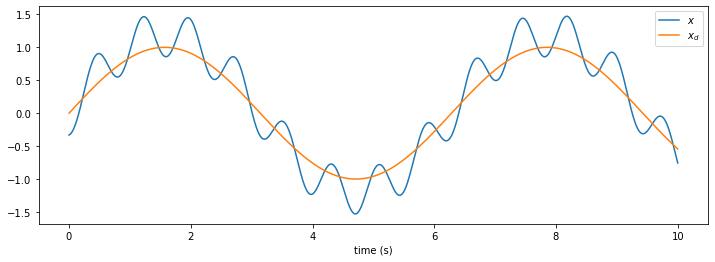

In [84]:
K_p = 1.0
        
dt = 0.001
T = 10.0  # amount of time to run simulation
n_steps = int(T/dt)
env = Pendulum(mass=4, max_torque=100, seed=1)

history = {}
history['x_d'] = np.empty(n_steps)
history['x'] = np.empty(n_steps)
t = np.arange(n_steps)*dt
for i in range(n_steps):
    x_d = np.sin(t[i])   # desired angle
    x = env.theta        # actual angle 
    
    u = K_p*(x_d - x)   # compute the P controller
    env.step(u)
    
    history['x_d'][i] = x_d
    history['x'][i] = x
    
    
plt.figure(figsize=(12,4))
plt.plot(t, history['x'], label='$x$')
plt.plot(t, history['x_d'], label='$x_d$')
plt.xlabel('time (s)')
plt.legend()
plt.show()    
    

Unsurprisingly, the system overshoots.  You can adjust $K_p$ to try to deal with that, but all you can really do here is reduce overshoot by slowing it down a lot.   So, now we add the $K_d$ term to make a PD controller.

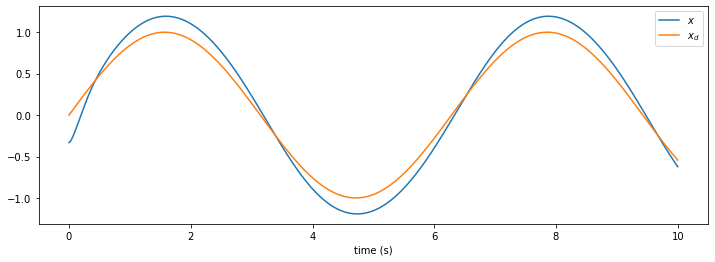

In [85]:
K_p = 1.0
K_d = 0.2
        
        
dt = 0.001
T = 10.0
n_steps = int(T/dt)
env = Pendulum(mass=4, max_torque=100, seed=1)

history = {}
history['x_d'] = np.zeros(n_steps)
history['x'] = np.zeros(n_steps)
t = np.arange(n_steps)*dt
for i in range(n_steps):
    x_d = np.sin(t[i])
    dotx_d = (x_d - history['x_d'][i-1])/dt
    
    x = env.theta
    dotx = env.dtheta
    
    u = K_p*(x_d - x) + K_d*(dotx_d - dotx)
    env.step(u)
    
    history['x_d'][i] = x_d
    history['x'][i] = x

    
plt.figure(figsize=(12,4))
plt.plot(t, history['x'], label='$x$')
plt.plot(t, history['x_d'], label='$x_d$')
plt.xlabel('time (s)')
plt.legend()
plt.show()    

Much better, but we're missing the target a lot.  This is due to gravity: at zero the arm is pointing straight up and there's no extra force due to gravity.  But when the arm angle is positive, we get extra positive torque, and when it is negative we get negative torque.  We can try removing gravity and seeing that it fixes the problem:

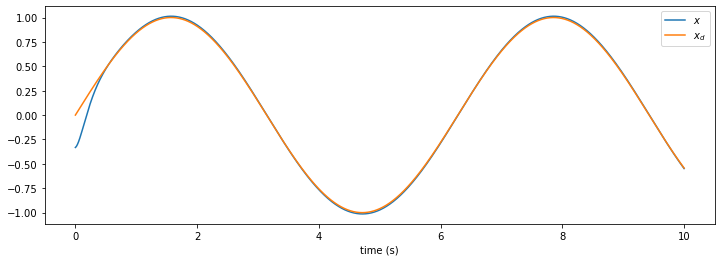

In [86]:
K_p = 1.0
K_d = 0.2
        
        
dt = 0.001
T = 10.0
n_steps = int(T/dt)
env = Pendulum(mass=4, max_torque=100, seed=1, g=0)

history = {}
history['x_d'] = np.zeros(n_steps)
history['x'] = np.zeros(n_steps)
t = np.arange(n_steps)*dt
for i in range(n_steps):
    x_d = np.sin(t[i])
    dotx_d = (x_d - history['x_d'][i-1])/dt
    
    x = env.theta
    dotx = env.dtheta
    
    u = K_p*(x_d - x) + K_d*(dotx_d - dotx)
    env.step(u)
    
    history['x_d'][i] = x_d
    history['x'][i] = x

    
plt.figure(figsize=(12,4))
plt.plot(t, history['x'], label='$x$')
plt.plot(t, history['x_d'], label='$x_d$')
plt.xlabel('time (s)')
plt.legend()
plt.show()    

But, in the real world we can't remove gravity, so instead let's add the $K_i$ term.

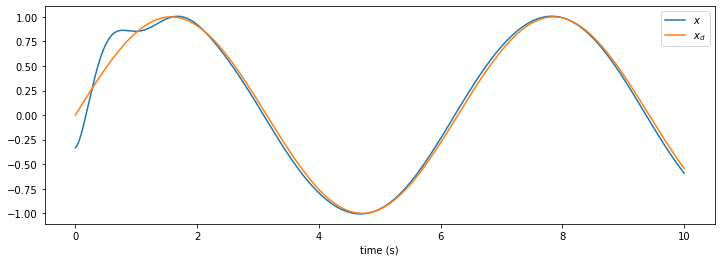

In [87]:
K_p = 1.0
K_d = 0.2
K_i = 2.0
        
        
dt = 0.001
T = 10.0
n_steps = int(T/dt)
env = Pendulum(mass=4, max_torque=100, seed=1)

history = {}
history['x_d'] = np.zeros(n_steps)
history['x'] = np.zeros(n_steps)
history['integral'] = np.zeros(n_steps)
t = np.arange(n_steps)*dt
for i in range(n_steps):
    x_d = np.sin(t[i])
    dotx_d = (x_d - history['x_d'][i-1])/dt
    
    x = env.theta
    dotx = env.dtheta
    
    integral = history['integral'][i-1] + dt*K_i*(x_d - x)
    
    u = K_p*(x_d - x) + K_d*(dotx_d - dotx) + K_i*integral
    env.step(u)
    
    history['x_d'][i] = x_d
    history['x'][i] = x
    history['integral'][i] = integral

    
plt.figure(figsize=(12,4))
plt.plot(t, history['x'], label='$x$')
plt.plot(t, history['x_d'], label='$x_d$')
plt.xlabel('time (s)')
plt.legend()
plt.show()    

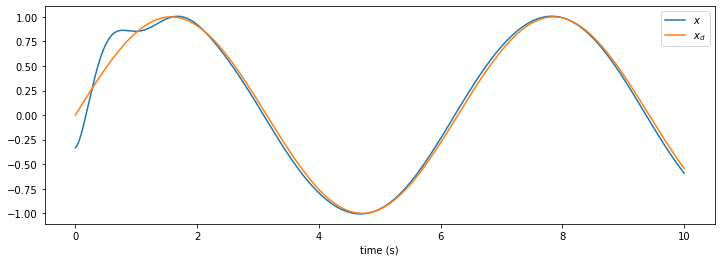

In [88]:
K_p = 1.0
K_d = 0.2
K_i = 2.0
        
        
dt = 0.001
T = 10.0
n_steps = int(T/dt)
env = Pendulum(mass=4, max_torque=100, seed=1)

history = {}
history['x_d'] = np.zeros(n_steps)
history['x'] = np.zeros(n_steps)
history['integral'] = np.zeros(n_steps)
t = np.arange(n_steps)*dt
for i in range(n_steps):
    x_d = np.sin(t[i])
    dotx_d = (x_d - history['x_d'][i-1])/dt
    
    x = env.theta
    dotx = env.dtheta
    
    integral = history['integral'][i-1] + dt*K_i*(x_d - x)
    
    u = K_p*(x_d - x) + K_d*(dotx_d - dotx) + K_i*integral
    env.step(u)
    
    history['x_d'][i] = x_d
    history['x'][i] = x
    history['integral'][i] = integral

    
plt.figure(figsize=(12,4))
plt.plot(t, history['x'], label='$x$')
plt.plot(t, history['x_d'], label='$x_d$')
plt.xlabel('time (s)')
plt.legend()
plt.show()    

Much better!  However, there is one very big problem with this approach:  Finding good $K_p$, $K_d$ and $K_i$ terms is hard, and it depends a lot on what the dynamics of the system are.  For example, if we increase the mass of the pendulum, we get this:

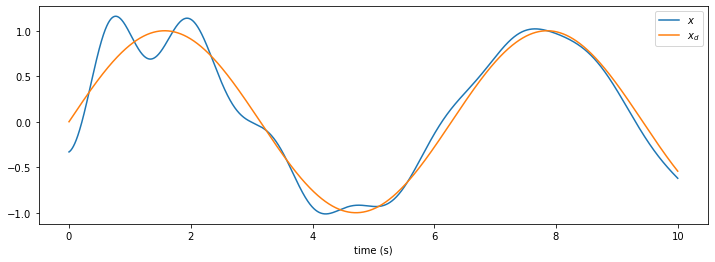

In [89]:
K_p = 1.0
K_d = 0.2
K_i = 2.0
        
        
dt = 0.001
T = 10.0
n_steps = int(T/dt)
env = Pendulum(mass=8, max_torque=100, seed=1)

history = {}
history['x_d'] = np.zeros(n_steps)
history['x'] = np.zeros(n_steps)
history['integral'] = np.zeros(n_steps)
t = np.arange(n_steps)*dt
for i in range(n_steps):
    x_d = np.sin(t[i])
    dotx_d = (x_d - history['x_d'][i-1])/dt
    
    x = env.theta
    dotx = env.dtheta
    
    integral = history['integral'][i-1] + dt*K_i*(x_d - x)
    
    u = K_p*(x_d - x) + K_d*(dotx_d - dotx) + K_i*integral
    env.step(u)
    
    history['x_d'][i] = x_d
    history['x'][i] = x
    history['integral'][i] = integral

    
plt.figure(figsize=(12,4))
plt.plot(t, history['x'], label='$x$')
plt.plot(t, history['x_d'], label='$x_d$')
plt.xlabel('time (s)')
plt.legend()
plt.show()    

This is one of the big limitations to PID control: you have to find good constants for the system, and tune them if the system changes.

Instead, let's do the adaptive PID controller.

For the features $A$, we just use an incredibly simple approach: we'll just compute $A=max(0, E \cdot x+B)$ where $E$ and $B$ are fixed randomly-chosen vectors.  $x$ in this case is just the scalar angle, but in general it could be a vector containing whatever state information we think might be useful for learning what extra force to apply (of course, if $x$ is a vector then $E$ will be a matrix). 

You will note that this equation is the same as a simple neural network with the input $x$ being directly multiplied by a connection weight matrix $E$, with rectified linear neurons, and each neuron having a bias $B$.

In general, though, we can do anything at all to generate the features $A$.  It does need to be a non-linear transformation of the state information, but other than that we are free to use whatever is easy to compute on the hardware we have.

For the example below, we use the `nengo` software package to randomly generate $E$ and $B$, just because it has some nice built-in tools for making sure we get a good variety of features $A$.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

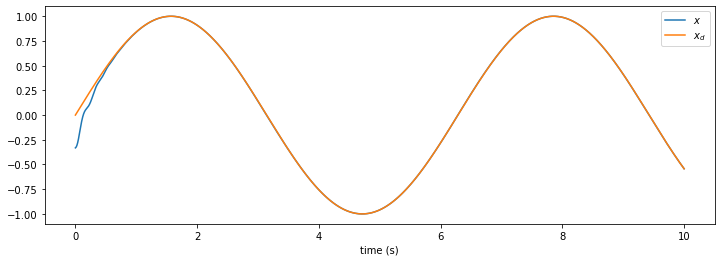

In [90]:
K_p = 1.0
K_d = 0.2
gamma = 1e-7
n_features = 100        
        
dt = 0.001
T = 10.0
n_steps = int(T/dt)
env = Pendulum(mass=4, max_torque=100, seed=1)

# use nengo to generate the E and B vectors
import nengo
model = nengo.Network()
with model:
    neurons = nengo.Ensemble(n_neurons=n_features, dimensions=1, neuron_type=nengo.RectifiedLinear())
sim = nengo.Simulator(model)
E = (sim.data[neurons].gain*sim.data[neurons].encoders.T)
B = sim.data[neurons].bias


history = {}
history['x_d'] = np.zeros(n_steps)
history['x'] = np.zeros(n_steps)

w = np.zeros((1, n_features))

t = np.arange(n_steps)*dt
for i in range(n_steps):
    x_d = np.sin(t[i])
    dotx_d = (x_d - history['x_d'][i-1])/dt
    
    x = np.array([env.theta])
    dotx = np.array([env.dtheta])
    
    u_pd = K_p*(x_d - x) + K_d*(dotx_d - dotx)
    
    A = np.maximum(0, np.dot(x,E) + B)
    
    w += gamma*A*u_pd
    
    u = u_pd + np.dot(w, A.T)
    env.step(u[0])
    
    history['x_d'][i] = x_d
    history['x'][i] = x

    
plt.figure(figsize=(12,4))
plt.plot(t, history['x'], label='$x$')
plt.plot(t, history['x_d'], label='$x_d$')
plt.xlabel('time (s)')
plt.legend()
plt.show()    

That's even better than the PID controller.  Now let's try it with a different mass.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

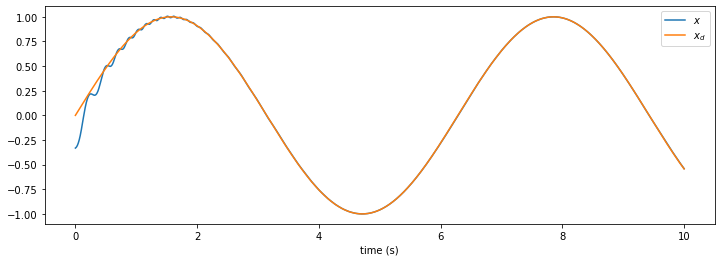

In [91]:
K_p = 1.0
K_d = 0.2
gamma = 1e-7
n_features = 100        
        
dt = 0.001
T = 10.0
n_steps = int(T/dt)
env = Pendulum(mass=8, max_torque=100, seed=1)

# use nengo to generate the E and B vectors
import nengo
model = nengo.Network()
with model:
    neurons = nengo.Ensemble(n_neurons=n_features, dimensions=1, neuron_type=nengo.RectifiedLinear())
sim = nengo.Simulator(model)
E = (sim.data[neurons].gain*sim.data[neurons].encoders.T)
B = sim.data[neurons].bias


history = {}
history['x_d'] = np.zeros(n_steps)
history['x'] = np.zeros(n_steps)

w = np.zeros((1, n_features))

t = np.arange(n_steps)*dt
for i in range(n_steps):
    x_d = np.sin(t[i])
    dotx_d = (x_d - history['x_d'][i-1])/dt
    
    x = np.array([env.theta])
    dotx = np.array([env.dtheta])
    
    u_pd = K_p*(x_d - x) + K_d*(dotx_d - dotx)
    
    A = np.maximum(0, np.dot(x,E) + B)
    
    w += gamma*A*u_pd
    
    u = u_pd + np.dot(w, A.T)
    env.step(u[0])
    
    history['x_d'][i] = x_d
    history['x'][i] = x

    
plt.figure(figsize=(12,4))
plt.plot(t, history['x'], label='$x$')
plt.plot(t, history['x_d'], label='$x_d$')
plt.xlabel('time (s)')
plt.legend()
plt.show()    

It works fine for other masses as well, without requiring us to adjust the $K_p$ and $K_d$ constants!  There is the new learning rate parameter `gamma` ($\gamma$) to replace $K_i$ but we don't have to tune it accross this sort of range.

## FPAA implementation (two alternatives)

The algorithm as specified so far seems like a good fit for an FPAA.  This is a basic neural network where the output is added to a PD controller.  However, there are two ways of thinking about where the weights $w$ are stored.

One possibility is to store them in the floating-gates themselves.  That is, this is an online learning rule and we adjust the stored values on-the-fly as per the learning rule.  This would involve doing the electron tunneling and what-not to make that happen.  There's probably also some interesting questions about positive and negative weights.

However, we could also go back to thinking about the weights as integrators, just like in the original PID controller.  That is, instead of doing any on-the-fly adjustment of floating-gate values, we instead have an integrator for each weight, and the value of the integrator is the weight itself.  The input to integrator $i$ would be $A_i u_{PD}$, and the output of the integrator would get multiplied by $A_i$ and summed to get $\sum A_i w_i$.  In this way we can do the same algorithm without on-the-fly programming.